#  Pronóstico de la bolsa de energía en Colombia utilizando Adalines


## Introducción
En el presente trabajo se realiza el ajuste de un modelo a los datos correspondientes a los precios históricos de la electricidad, entre julio de 1995 y mayo del 2018; extraídos de la Bolsa de Energía de Colombia.

El propósito de esto es obtener pronósticos para el precio promedio diario de la electricidad para los próximos siete días y determinar el modelo más adecuado.   

## Lectura de datos

In [0]:
## Carga de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
## List of years to read 
first_year = 1995; last_year = 2019
years = list(map(str, list((range(first_year, last_year)))))

## Data had differente extensions for the last 3 dataframes
exts = (list(np.repeat(".xlsx",21))+
        list(np.repeat(".xls",3)))
       
## Urls of dataframes
urls = ["https://github.com/ANN-2019-2/evaluacion-jfmra99/raw/master/datos/precios/Precio_Bolsa_Nacional_(%24kwh)_"
 + year + ext for year, ext in zip(years, exts)]

## Read a df
def xslx_reader(path, skip_rows):
  d = pd.read_excel(io= path, 
                    header = 0, #Header position after skipping rows
                    skiprows= skip_rows, ## data.frames start in row 2 or 3
                    usecols = "A:Y", # Just don't read thinks beyoung bounds
                    dtype= {"Fecha" : np.datetime64}

                    )
  return d

## Df donde guardar las 24 bases
df = pd.DataFrame(
    columns=["Fecha", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", 
             "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", 
             "21", "22", "23"]
    )
sizes = []
#Frame = Frame.append(pandas.DataFrame(data = SomeNewLineOfData), ignore_index=True)
for i in range(0, 24):

  if(i<5):
    nrow = 3 # first 5 dfs start in row 3
  else:
    nrow=2 # the others start in row 2

  df_temp = xslx_reader(urls[i], skip_rows=nrow)

  if(i!=0 and i!=18):## First day of 1995 is a NA. And there are NAs within 2013
    df_temp = df_temp.dropna() 
  elif(i==18): #the last two rows are Completely Nas, but there are other NAs
    df_temp = df_temp[df_temp.Fecha.notnull()] 

  df_temp = df_temp.drop_duplicates() ## There are several dupplicates among df 16-18
  sizes = [sizes, df_temp.shape[0]]
  df = df.append(df_temp, ignore_index=True) ## we bind the dfs together.

        

Se realiza un chequeo rápido de si nuestro conjunto de datos ha sido cargado correctamente, para ello calculamos el número de días transcurridos desde la fecha inicial 20/07/1995 hasta la fecha final 05/05/2018, y verificamos que sea equivalente al número de filas de nuestro conjunto de dajos

In [3]:
from datetime import date
f_date = date(1995, 7, 19) 
l_date = date(2018, 5, 5)
delta = l_date - f_date # Last_day - first_day + 1
print(delta.days - df.shape[0])

0


Aparentemente nuestro conjunto de datos fue filtrado correctamente, ahora procedemos a calcular un estimador del precio de la bolsa de energía durante el día, en este caso utilizaremos la media de las 24 horas.

In [4]:
df['Precio_prom'] = (df.loc[:, df.columns != 'Fecha']).mean(axis=1, skipna=True) # Media del precio en el día, ignora los na
ts_df = (df[['Fecha', 'Precio_prom']])
ts_df

,Fecha,Precio_prom
0,1995-07-20,1.409435
1,1995-07-21,4.924333
2,1995-07-22,1.269500
3,1995-07-23,0.953083
4,1995-07-24,4.305917
...,...,...
8321,2018-05-01,71.666726
8322,2018-05-02,76.374441
8323,2018-05-03,71.148348
8324,2018-05-04,64.710120


## Ajuste por inflación

Debido a que los precios están dados a la escala del tiempo que fueron tomados, para remover la tendencia creciente en la serie de tiempo hemos de ajustar el precio por la inflación, nos basaremos en el IPC (índice de precios del consumidor) obtenido en la página del [Dane](https://systema39.dane.gov.co/cipc/inicio.do), para hacer la estimación del cambio del valor adquisitivo. **Se quiere traer los valores a un equivalente del último registro 2018-05-05**, con lo que se define un escalador de inflación `Infl_escalador`:

$$Infl\_escalador_i = \frac{IPC_{2018-05}}{IPC_{i}} = \frac{99.16}{IPC_i}$$

De manera que el precio traído a valor actual sería:

$$Precio\_actual_i = Precio\_prom_i * Infl\_actual_i$$


In [6]:
# Reading ipc values
ipc = pd.read_excel(io= "https://github.com/ANN-2019-2/evaluacion-jfmra99/raw/master/01-precios-SOLUCI%C3%93N/IPC_mensual_DANE.xlsx",
                    usecols = "A:B",
                    skiprows = 12, #df start in row 13
                    dtype = {"Año(aaaa)-Mes(mm)": str}) #tried to read as date but failed

ipc['Infl_escalador'] = 99.16/ipc['Índice'].values #calculation of the escalator

#Create an equivalent to "Año(aaaa)-Mes(mm)" so we can make a join between the two dataframes
ts_df['fecha_str'] = ((pd.DatetimeIndex(ts_df['Fecha']).year).astype(str) + 
                 (pd.DatetimeIndex(ts_df['Fecha']).month.map("{:02}".format)).astype(str)) 
ipc.dropna()[['Año(aaaa)-Mes(mm)', 'Infl_escalador']]

## Left join between the dfs:
final_df = pd.merge(ts_df, ipc,  
                    how='left', 
                    left_on=['fecha_str'], right_on = ['Año(aaaa)-Mes(mm)'])

## Compute of the actual price = old_price * excalator
final_df['Precio_actual'] = final_df['Precio_prom'].values * final_df['Infl_escalador'].values
## Columns that matter to us
final_df = final_df[['Fecha', 'Precio_prom', 'Infl_escalador', 'Precio_actual']]
final_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Fecha,Precio_prom,Infl_escalador,Precio_actual
0,1995-07-20,1.409435,4.737697,6.677475
1,1995-07-21,4.924333,4.737697,23.330000
2,1995-07-22,1.269500,4.737697,6.014506
3,1995-07-23,0.953083,4.737697,4.515420
4,1995-07-24,4.305917,4.737697,20.400129
...,...,...,...,...
8321,2018-05-01,71.666726,1.000000,71.666726
8322,2018-05-02,76.374441,1.000000,76.374441
8323,2018-05-03,71.148348,1.000000,71.148348
8324,2018-05-04,64.710120,1.000000,64.710120


Un gráfico de nuestra serie de precios actuales en función del tiempo será:

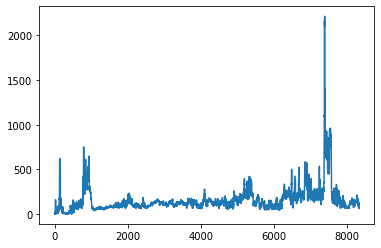

In [7]:
final_df['Precio_actual'].plot()

## Funciones de estabilización de varianza:
Se proponen las siguiente funciones para estabilizar la varianza:

- $p(y) = y$ (Función identidad para considerar en el ajuste del modelo).
- $q(y) = \ln(y)$ 
- $r(y)=\log_{10}(y)$ 
- $s(y) = \sqrt y$
- $t(y) = y^{-1}$
- $u(y) = \sqrt[4]{y}$

Definimos las funciones para obtener los valores de la transformación y la función inversa para obtener los valores reales (equivalentes a $Precio\_prom$):

In [0]:
## Transform time series to get 
def get_prec_actual(y = final_df[['Precio_actual']], fun = 'p'):
  if(fun == 'q'):
    return np.log(y)
  
  elif(fun == 'r'):
    return np.log10(y)

  elif(fun == 's'):
    return np.sqrt(y+0.000000000000001)
  
  elif(fun == 't'):
    return np.power(y, -1)

  elif(fun == 'u'):
    return np.power(y, 1/4)
  
  else:
    return y

## Get original values of the time series
def get_prec_original(y, escale = final_df[['Infl_escalador']],fun = 'p', doescale=False):
  if not(doescale):
    escale=1
  if(fun == 'q'):
    return np.exp(y)* (1/escale)
  
  elif(fun == 'r'):
    return np.power(10, y) * (1/escale)

  elif(fun == 's'):
    return np.power(y, 2) * (1/escale)
  
  elif(fun == 't'):
    return np.power(y, -1) * (1/escale)

  elif(fun == 'u'):
    return np.power(y, 4) * (1/escale)
  
  else:
    return y * (1/escale)


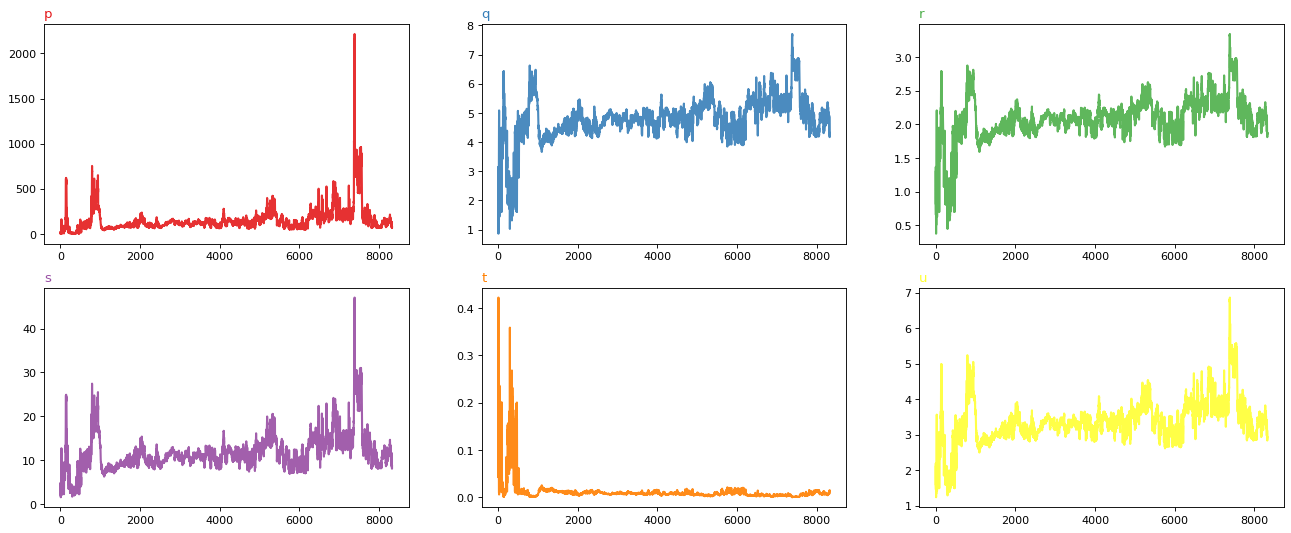

In [9]:
fig=plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
func = ['p','q', 'r', 's', 't', 'u'] ## list of functions
palette = plt.get_cmap('Set1')

for i in range(1, 7):

    # Find the right spot on the plot
    plt.subplot(2,3, i)
 
    # Plot the lineplot
    plt.plot(final_df['Fecha'].index.values, get_prec_actual(fun = func[i-1]), marker='', color=palette(i-1), linewidth=1.9, alpha=0.9)
 
    # Same limits for everybody!
    #plt.xlim(0,200)
    #plt.ylim(0,50)
 
 
    # Add title
    plt.title(func[i-1], loc='left', fontsize=12, fontweight=0, color=palette(i-1) )



En general, se considera que las que logran estabilizar mejor la varianza de la serie son las dos transformaciones logarítmicas. Se puede ver que muchas de las transformaciones siguen teniendo valores muy grandes en el eje y. Por lo que se utilizará una función de escalado que lleve a cada transformación al rango de (0,1).

## Función de escalado

In [0]:
# Diccionario donde se guardan minimos y maximos del escalado para cada una de las funciones
min_max = {}

# Añadimos minimos y maximos al diccionario
for f in func:
  transf = get_prec_actual(fun = f)
  min_max[f] = [np.min(transf), np.max(transf)]

#Funcion de escalado
def scale(y, fun):
  min = (min_max[fun])[0]
  max = (min_max[fun])[1]

  return((y-min)/(max-min))

#Funcion de desescalado
def unscale(y, fun):
  min = (min_max[fun])[0].values
  max = (min_max[fun])[1].values

  return((y)*(max-min)+min)


## Ajuste del modelo

A continuación, se define nuestro Adaline para el ajuste:

```
# Tiene formato de código
```



In [0]:
class Adaline:
    def __init__(self,
                 learning_rate=0.001, # tasa de aprendizaje
                 momentum=0.001,      # momentum 
                 R=7,  # número de retardos a usar
                 ):   #

        self.learning_rate = learning_rate
        self.momentum = momentum
        self.R = R
        self.coef_ = np.zeros(R)
        self.intercept_ = np.zeros(1)
        self.X = []

    def predict(self):
      if len(self.X) <self.R:
        return None
      X = np.array(self.X)
      
      u = np.dot(X, self.coef_) + self.intercept_
      return(u)

    def fit(self, y):

        y_adj = self.predict()

        if y_adj is not None:
          e = y - y_adj
          #Nuevo calculo de los coeficientes del modelo:
          self.coef_ += 2*self.learning_rate * e *np.array(self.X) +self.coef_*self.momentum

          self.intercept_ += 2 * self.learning_rate * e + self.intercept_*self.momentum

        self.X.append(y)

        if len(self.X) > self.R:
            self.X.pop(0)


## Elección de parámetros de ajuste y transformación

A continuación, se construyen regillas para los parámetros del modelo:
- Transformación: la transformación utilizada en el precio de la bolsa de energía.
- Rezagos: el número de observaciones que tiene en cuenta el Adaline a la hora de actualizar los pesos. Dado que se asume una periodicidad semanal se utilizaron (7,14,21) días de rezagos.
- Tasa de aprendizaje: se probaron [0.0005, 0.0055, 0.0105, 0.0155, 0.0205, 0.0255, 0.0305, 0.0355, 0.0405, 0.0455, 0.0505, 0.0555, 0.0605, 0.0655, 0.0705, 0.0755, 0.0805, 0.0855, 0.0905, 0.0955].
- Momentum: al probar con diferentes valores de momentum, se encontró que con valores mayores a 0.001 hacía que el ADALINE se alejará drásticamente de la serie real, por lo que se probaron valores muy pequeños [0, 0.0002, 0.0004, 0.0006, 0.0008, 0.001 ].

In [0]:
Res_tranf = pd.DataFrame(columns= ["Transformación", "MSE",
                                   "Tasa_de_aprendizaje", "Momentum", "N_retardos",
                                   "Modelo", "Pronos"
                                   ]) ## Arreglo de resultados
Rezagos = np.arange(7, 22, 7) #se prueban retardos de cada semana
tasas_aprendizaje = np.arange(0.0005,0.1, 0.005)
momentum = np.arange(0, 0.0011, 0.0002)

for fun in func: ## Para cada una de las funciones
  #res_temp = pd.DataFrame(["MSE entrenamiento", "MSE pronostico", 
   #                        "Tasa_de_aprendizaje", "Momentum", 
    #                       "N_retargos"]) # Resultados para cada combinación de valores
  d = scale(get_prec_actual(fun = fun), fun = fun)
  d = d.iloc[:,0].values
  for rate in tasas_aprendizaje:
    for momen in momentum:
      
      for R in Rezagos:
        
        Ada = Adaline(learning_rate=rate,
                      momentum=momen,
                      R=R ## número de rezados 
                      )
        forecasts0 = []

        for z in d:
          forecasts0.append(Ada.predict())
          Ada.fit(z)
        
        forecasts0 = unscale(np.array(forecasts0[(R+1):]), fun = fun)
        forecasts0 = get_prec_original(forecasts0, fun = fun)

        #d_temp = unscale(d[(R+1):], fun = fun)
        
        #d_temp = get_prec_original(d_temp, fun = fun)
        
        d_temp = get_prec_actual(fun = "p").loc[R+1:,]
        
        
        #d_temp = d[(R+1):]
        #forecasts0 = forecasts0[(R+1):]
        
        
        #d = get_prec_original(pd.DataFrame(d[(R+1):]), 
        #                               escale=final_df.loc[(R+1):,['Infl_escalador']], 
        #                               fun = fun)
        
        ## Luego tienes que extraer los valores de error de entrenamiento y pronostico del Adaline
        Res_tranf = Res_tranf.append({
            "Transformación": fun,
            "MSE": np.mean(np.power(np.array(forecasts0) - np.array(d_temp), 2)),
            "Tasa_de_aprendizaje": rate,
            "Momentum": momen,
            "N_retardos": R,
            "Pronos": forecasts0,
            "Modelo": Ada
        }, ignore_index=True)






A continuación, se presentan los 10 mejores modelos según su error de pronóstico:


In [60]:
pd.set_option('max_rows', 99999) # To display more rows
best_models = Res_tranf.sort_values(by=['MSE']).head(10)
best_models.loc[:,Res_tranf.columns.difference(["Modelo" ,"Pronos"])]
#order(Res_tranf['MSE'])

,MSE,Momentum,N_retardos,Tasa_de_aprendizaje,Transformación
171,796.788475,0.0,7,0.0855,r
111,796.788475,0.0,7,0.0855,q
174,797.315952,0.0,7,0.0905,r
114,797.315952,0.0,7,0.0905,q
108,799.663962,0.0,7,0.0805,q
168,799.663962,0.0,7,0.0805,r
177,801.535365,0.0,7,0.0955,r
117,801.535365,0.0,7,0.0955,q
105,805.699305,0.0,7,0.0755,q
165,805.699305,0.0,7,0.0755,r


El mejor modelo ajustado fue el 171, utilizó la transformación $r = \log_{10}{(y)}$, un Momentum de $0$, una tasa de aprendizaje de $0.0855$ y $7$ rezagos. Se puede ver que el segundo y tercer mejor modelo tan solo varían en la tasa de aprendizaje (manteniendo valores relativamente altos) y la transformación de la variable respuesta.

Se destaca que los 10 mejores modelos usaron las transformaciones q y r, que corresponde a $log_{10}$ y al $ln$, estas fueron las que mejor lograron estabilizar la varianza.

El gráfico de los valores ajustados de la serie dentro del conjunto de entrenamiento se presentan a continuación:

8318
8326


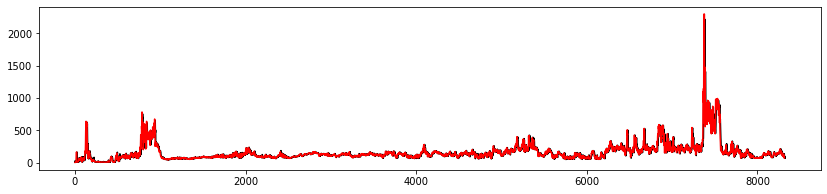

In [63]:
best_model = best_models.loc[171,]
final_model = (best_model['Modelo'])
pronos = (best_model['Pronos'])
print(len(pronos))
print(len(get_prec_actual(fun = "p")))



Ada = Adaline(learning_rate=0.005,
                      momentum=0,
                      R=7 ## número de rezados 
                      )


plt.figure(figsize=(14,3))
plt.plot(get_prec_actual(fun = "p"), color='black');
plt.plot(pronos, color = 'red');

#np.mean(np.power(np.array((forecasts0[10:]))- np.array(d[10:]),2))

#np.power(np.max(np.array((forecasts0[100:]))- np.array(d[100:])),2)

## Conclusiones

- Los adalines son una herramienta muy útil para hacer predicciones a corto plazo, ya que permite corregir rápidamente las desviaciones de los datos.
- Las mejores transformaciones fueron las logarítmicas, que son las usualmente usadas para estabilizar varianza.
- El escalado de la variable respuesta mejora el ajuste del modelo significativamente.
- El número de retardos óptimo probo ser 7, utilizar más retardos tiende a empeorar las predicciones del modelo.